In [2]:
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import os
import pickle
from torchvision import transforms
import pytorch_lightning as pl
import torch

# load own code
import sys
sys.path.append('../')
from sleeplib.Resnet_15.model import FineTuning
from sleeplib.datasets import BonoboDataset, ContinousToSnippetDataset
# this holds all the configuration parameters
from sleeplib.config import Config
import pickle

from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
from torchvision import transforms

from sleeplib.datasets import BonoboDataset , ContinousToSnippetDataset
from sleeplib.montages import CDAC_bipolar_montage,CDAC_common_average_montage,CDAC_combine_montage
from sleeplib.transforms import cut_and_jitter, CDAC_bipolar_signal_flip,CDAC_monopolar_signal_flip


In [3]:
path_model = 'Models/YOUR_MODEL_NAME'
# load config file
with open(path_model+'/config.pkl', 'rb') as f:
   config = pickle.load(f)
# load dataset
df = pd.read_csv(config.PATH_LUT_BONOBO,sep=';')
# fraction filter
frac_filter = (df['fraction_of_yes'] > 6/8) | (df['fraction_of_yes'] < 2/8)
mode_filter = df['Mode'] == 'Test'
extreme_quality_filter = df['total_votes_received'] >= 8
quality_filter = df['total_votes_received'] > 2

test_df = df[mode_filter]
print(f'there are {len(test_df)} test samples')

there are 3100 test samples


In [4]:
# set up dataloader to predict all samples in test dataset
transform_val = transforms.Compose([cut_and_jitter(windowsize=config.WINDOWSIZE,max_offset=0,Fq=config.FQ)])
bipolar_montage = CDAC_bipolar_montage()
common_average_montage = CDAC_common_average_montage()
test_dataset = BonoboDataset(test_df, config.PATH_FILES_BONOBO, transform=transform_val,bipolar_montage=bipolar_montage, common_average_montage=common_average_montage)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=os.cpu_count())


In [5]:
Bonobo_con = ContinousToSnippetDataset('/home/ubuntu/data/Bonobo01742_0.mat',montage=montage)
con_dataloader = DataLoader(Bonobo_con, batch_size=config.BATCH_SIZE,shuffle=False,num_workers=os.cpu_count())

for x, y in con_dataloader:
    with torch.no_grad():
        print(x.shape)
        print(y)
        break

torch.Size([128, 18, 128])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


In [6]:
# load pretrained model
model = FineTuning.load_from_checkpoint('/home/ubuntu/code/Spike_transformer/Models/YOUR_MODEL_NAME/weights-v3.ckpt',
                                        lr=config.LR,
                                        head_dropout=config.HEAD_DROPOUT,
                                        n_channels=config.N_CHANNELS,
                                        n_fft=config.N_FFT,
                                        hop_length=config.HOP_LENGTH,
                                       )
                                        #map_location=torch.device('cpu') add this if running on CPU machine
# init trainer
trainer = pl.Trainer(fast_dev_run=False,enable_progress_bar=False)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
# predict all samples
preds = trainer.predict(model,test_dataloader)
preds = np.concatenate(preds)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [8]:
# store results
results = test_df[['event_file','fraction_of_yes','total_votes_received','Mode']].copy()
results['preds'] = preds
results.to_csv(path_model+'/predictions.csv',index=False)

In [8]:
# store results
'''

preds = trainer.predict(model,con_dataloader)
preds = np.concatenate(preds)

preds = pd.DataFrame(preds)
preds.to_csv(path_model+'/predictions.csv',index=False)

In [4]:
import scipy.io
import pandas as pd

# 加载 .mat 文件
mat_file_path = '/home/ubuntu/data/Bonobo_scores_afterRound3_spread_2023Jan31.mat'
mat_data = scipy.io.loadmat(mat_file_path)
print('1')
# 从 .mat 数据中提取一个变量
variable_name = 'your_variable_name'
data = mat_data['lut_pseudo']

# 将数据转换为 DataFrame
data_frame = pd.DataFrame(data)
print('2')

# 保存为 CSV 文件
csv_file_path = '/home/ubuntu/data/pseudo.csv'
data_frame.to_csv(csv_file_path, index=False)


1
2


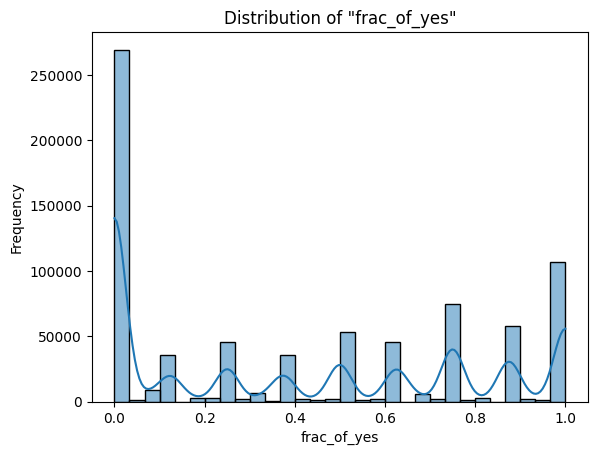

count    771512.000000
mean          0.412493
std           0.384477
min           0.000000
25%           0.000000
50%           0.375000
75%           0.750000
max           1.000000
Name: 7, dtype: float64

In [22]:
import pandas as pd
# Importing necessary libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# 指定CSV文件的路径
csv_file_path = '/home/ubuntu/data/pseudo.csv'

# 读取CSV文件
data = pd.read_csv(csv_file_path)

second_last_column = data.iloc[:, -2]

# 由于该列看起来包含在双重列表中，我们可能需要进行一些转换
second_last_column_values = second_last_column.apply(lambda x: eval(x)[0][0])


# Plotting the histogram for the 'preds' column
plt.figure
sns.histplot(second_last_column_values, bins=30, kde=True)
plt.title('Distribution of "frac_of_yes"')
plt.xlabel('frac_of_yes')
plt.ylabel('Frequency')
plt.show()

# Providing summary statistics for the 'preds' column
summary_statistics = second_last_column_values.describe()
summary_statistics

In [15]:
summary_statistics = data.iloc[:, 7].describe()
summary_statistics

count     771512
unique        59
top        [[0]]
freq      269279
Name: 7, dtype: object

In [24]:
from collections import Counter
import re

third_last_column = data.iloc[:, -3]

# 定义一个函数，用于从字符串中提取所有的单词
def extract_words(text):
    # 使用正则表达式匹配单词
    return re.findall(r"'(\w+)'", text)

# 应用该函数提取倒数第三列中的所有单词
words_third_last_column = third_last_column.apply(extract_words)

# 合并所有的单词列表并统计频率
words_frequency = Counter([word for sublist in words_third_last_column for word in sublist])

# 将频率转换为 DataFrame，以便更好地展示
words_frequency_df = pd.DataFrame.from_dict(words_frequency, orient='index', columns=['Frequency']).reset_index()
words_frequency_df.rename(columns={'index': 'Word'}, inplace=True)

# 按频率降序排列
words_frequency_df = words_frequency_df.sort_values(by='Frequency', ascending=False)

# 显示前几个单词及其频率
words_frequency_df.head()


,Word,Frequency
0,mbw,771512
3,jon,680472
6,ioannis,502269
7,marcus,502269
2,jj,401494


In [25]:
words_frequency_df

,Word,Frequency
0,mbw,771512
3,jon,680472
6,ioannis,502269
7,marcus,502269
2,jj,401494
1,fabio,401353
4,alice,371754
5,aline,371754
8,syd,371754
9,doug,371754
